In [1]:
import time
import os
import sys
import copy
import pickle
import networkx as nx
import pandas as pd
import numpy as np

import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt
from collections import defaultdict
from scipy import sparse

from torch.autograd import Variable
from models.models import MLP
from data import datasets
from data.gene_graphs import GeneManiaGraph, RegNetGraph
from data.utils import record_result
from data.clinical.datasets import TCGADataset, Task
from data.clinical import taskloader
from data.clinical import split_dataset

from models.models import MLP, GCN, SLR

%load_ext autoreload
%autoreload 2

In [2]:
# Load the gene expression dataset
tcga = TCGADataset()

# Cut it into clinical tasks
task_ids = taskloader.get_all_tasks(tcga)
tasks = [Task(tcga, task_id, limit=1000) for task_id in task_ids]

# load the gene-gene interaction graph
graphs = {"genemania": GeneManiaGraph()}

Torrent name: TCGA_tissue_ppi.hdf5, Size: 1748.32MB
Torrent name: genemania.pkl, Size: 9.61MB


In [6]:
# We store our results for this experiment in this file, it is tracked in git and contains a pickled pandas DataFrame 
filename = "experiments/results/clinical-tasks.pkl"
try:
    # try to load the results file
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    print(e)
    # If we can't find the results file, instantiate a new dataframe
    results = pd.DataFrame(columns=['task', 'auc', 'model', 'graph', 'seed', 'train_size', 'time_elapsed'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [7]:
# Define the experimental conditions to evaluate
trials = 3
train_size = 50
test_size = 200
cuda = True
models = [
              #GCN(name="GCN_lay20_chan32_emb32_dropout_pool_kmeans", cuda=cuda, dropout=True, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="kmeans"),
              # GCN(name="GCN_lay20_chan32_emb32_dropout_pool_hierarchy", cuda=cuda, dropout=True, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="hierarchy"),
              #GCN(name="GCN_lay20_chan32_emb32_dropout_pool_random", cuda=cuda, dropout=True,num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="random"),
              GCN(name="GCN_lay3_chan64_emb32_dropout_pool_hierarchy", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32, pooling="hierarchy"),
              GCN(name="GCN_lay3_chan64_emb32_dropout", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32),
              MLP(name="MLP_lay2_chan512_dropout", cuda=cuda, dropout=True, num_layer=2, channels=512),
              MLP(name="MLP_lay2_chan512", cuda=cuda, dropout=False, num_layer=2, channels=512),
              #SLR(name="SLR_lambda1_l11", cuda=cuda)
             ]

In [8]:
# We create a unique identifier for each experiment, and find the experiments which we still have to do (i.e. not in results file)

columns = ["task", "graph", "model", "seed", "train_size"]
all_exp_ids = [x for x in itertools.product([task.id for task in tasks], graphs.keys(), [model.name for model in models], range(trials), [train_size])]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")

print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 3480
done: 13


In [10]:
for row in todo:

    start_time = time.time()
        
    # Get the experimental conditions
    graph_name = row["graph"]
    gene_graph = graphs[graph_name]
    seed = row["seed"]
    model = [copy.deepcopy(model) for model in models if model.name == row["model"]][0]
    task = [copy.deepcopy(task) for task in tasks if task.id == row["task"]][0]
    test_size = min(test_size, len(task.labels - train_size))
    experiment = {
        "task": task.id,
        "model": model.name,
        "graph": graph_name,
        "seed": seed,
        "train_size": train_size,
    }

    print(experiment)
    if len(results) % 10 == 0: print(len(results))

    try:
        # Split the dataset into train and test sets
        X_train, X_test, y_train, y_test = sklearn.model_selection.\
            train_test_split(task.get_data(), task.labels, stratify=task.labels, 
                             train_size=train_size, test_size=test_size)
    except ValueError as e:
        # If the task is too unbalanced, we don't run the experiment and record a result
        print(e)
        results = record_result(results, experiment, filename)
        continue

    # Copy the data out of the task
    X_train = X_train.copy()
    X_test = X_test.copy()
    y_train = y_train.astype("uint8")

    # Try to fit the model
    model.fit(X_train, y_train, adj=np.asarray(nx.to_numpy_matrix(gene_graph.nx_graph)))
    x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
    if cuda: 
        x_test = x_test.cuda()

    y_hat = []
    for i in range(x_test.shape[0] // 2):
        batch = x_test[2*i:2*(i+1)]
        y_hat.extend(model.predict(batch)[:, 1].data.cpu().numpy().tolist())
    auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
    experiment["auc"] = auc
    experiment["time_elapsed"] = str(time.time() - start_time)
    experiment["cuda"] = cuda
    print(experiment)
    results = record_result(results, experiment, filename)


{'task': 'gender-GBMLGG', 'model': 'GCN_lay3_chan64_emb32_dropout_pool_hierarchy', 'graph': 'genemania', 'seed': 0, 'train_size': 50}
setup layers took: 2.1224498748779297
epoch: 0 0.21861910820007324
epoch: 1 0.2174067497253418
epoch: 2 0.2154831886291504
epoch: 3 0.21456670761108398
epoch: 4 0.21407604217529297
epoch: 5 0.21398568153381348
epoch: 6 0.21427536010742188
epoch: 7 0.21558642387390137
epoch: 8 0.21398210525512695
epoch: 9 0.21407651901245117
epoch: 10 0.21407556533813477
epoch: 11 0.2139110565185547
epoch: 12 0.21564841270446777
epoch: 13 0.21443772315979004
epoch: 14 0.21459126472473145
epoch: 15 0.2141411304473877
epoch: 16 0.2143561840057373
epoch: 17 0.21647930145263672
epoch: 18 0.2144923210144043
epoch: 19 0.21424174308776855
epoch: 20 0.21538996696472168
epoch: 21 0.21635770797729492
epoch: 22 0.21468329429626465
total train time:14.763307809829712 for epochs: 23
{'task': 'gender-GBMLGG', 'model': 'GCN_lay3_chan64_emb32_dropout_pool_hierarchy', 'graph': 'genemania'

KeyboardInterrupt: 

In [12]:
results.groupby(["task", "model"]).mean()

auc  cuda
task          model                                                        
gender-BLCA   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  0.708319   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.913971   1.0
              MLP_lay2_chan512                               0.593690   1.0
              MLP_lay2_chan512_dropout                       0.535921   1.0
gender-BRCA   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.463805   1.0
              GCN_lay3_chan64_emb32_dropout                  0.452020   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.447811   1.0
              MLP_lay2_chan512                               0.388889   1.0
              MLP_lay2_chan512_dropout                       0.718013   1.0
gender-COAD   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  1.000000   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.656099   1.0
              MLP_lay2_chan512                               0.609300   1.0
              MLP_lay2_chan512_dropout                       0.475845   1.0
gender-GBMLGG GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.613288   1.0
              GCN_lay20_chan32_emb32_dropout_pool_kmeans     0.594559   1.0
              GCN_lay3_chan64_emb32_dropout                  0.925930   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.770672   1.0
              MLP_lay2_chan512                               0.631478   1.0
              MLP_lay2_chan512_dropout                       0.568901   1.0
gender-HNSC   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  0.802250   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.712446   1.0
              MLP_lay2_chan512                               0.679973   1.0
              MLP_lay2_chan512_dropout                       0.595752   1.0
gender-KIRC   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  0.899805   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.669506   1.0
              MLP_lay2_chan512                               0.729063   1.0
...                                                               ...   ...
gender-LUAD   MLP_lay2_chan512_dropout                       0.583216   1.0
gender-LUSC   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  0.797801   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.635417   1.0
              MLP_lay2_chan512                               0.657755   1.0
              MLP_lay2_chan512_dropout                       0.522917   1.0
gender-PCPG   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.729798   1.0
              MLP_lay2_chan512                               0.816498   1.0
              MLP_lay2_chan512_dropout                       0.513047   1.0
gender-SARC   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.506061   1.0
              GCN_lay3_chan64_emb32_dropout                  0.886768   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.762458   1.0
              MLP_lay2_chan512                               0.729226   1.0
              MLP_lay2_chan512_dropout                       0.566801   1.0
gender-SKCM   GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.500000   1.0
              GCN_lay3_chan64_emb32_dropout                  0.864141   1.0
              GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.702143   1.0
              MLP_lay2_chan512                               0.685024   1.0
              MLP_lay2_chan512_dropout                       0.609614   1.0
gender-STAD   GCN_lay20_chan32_emb32_d

In [14]:
(results.groupby(["model"]).mean(), results.groupby(["model"]).var())

(                                                    auc  cuda
 model                                                        
 GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.505544   1.0
 GCN_lay20_chan32_emb32_dropout_pool_kmeans     0.594559   1.0
 GCN_lay3_chan64_emb32_dropout                  0.837681   1.0
 GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.706072   1.0
 MLP_lay2_chan512                               0.674239   1.0
 MLP_lay2_chan512_dropout                       0.572897   1.0,
                                                     auc  cuda
 model                                                        
 GCN_lay20_chan32_emb32_dropout_pool_hierarchy  0.002354   0.0
 GCN_lay20_chan32_emb32_dropout_pool_kmeans     0.005121   0.0
 GCN_lay3_chan64_emb32_dropout                  0.030310   0.0
 GCN_lay3_chan64_emb32_dropout_pool_hierarchy   0.033350   0.0
 MLP_lay2_chan512                               0.015081   0.0
 MLP_lay2_chan512_dropout                       0.0191

In [19]:
len(results.task.unique())

15

In [26]:
subset = results

q = subset.groupby(['model'])['auc']
print(q.mean())

model
GCN_lay20_chan32_emb32_dropout_pool_hierarchy    0.505544
GCN_lay20_chan32_emb32_dropout_pool_kmeans       0.594559
GCN_lay3_chan64_emb32_dropout                    0.837681
GCN_lay3_chan64_emb32_dropout_pool_hierarchy     0.706072
MLP_lay2_chan512                                 0.674239
MLP_lay2_chan512_dropout                         0.572897
Name: auc, dtype: float64


/media/martin/the_milano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.


(0.5, 0.9)

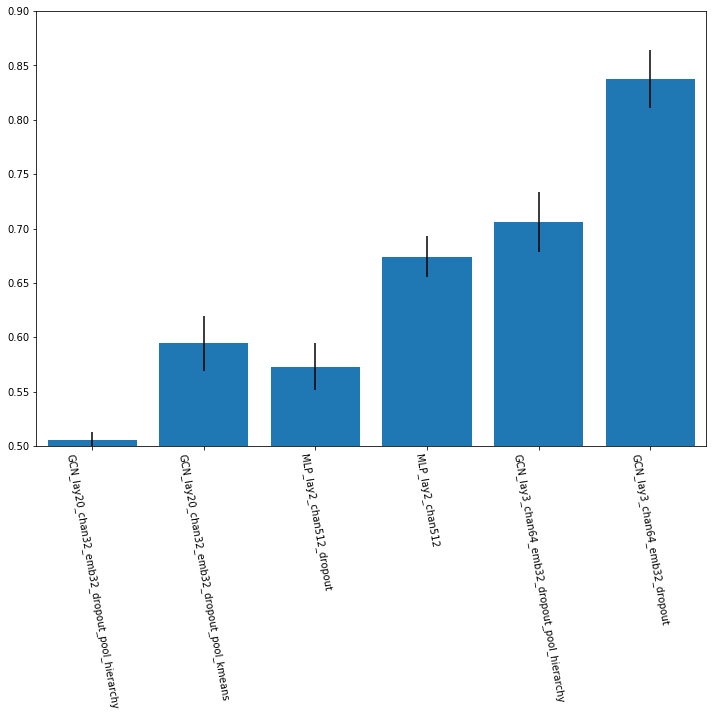

In [36]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.5, 3.6)
plot_train_size = 50

subset = results

q = subset.groupby(['model'])['auc']

stderr = []
mean = []
labels = []
for model in set(subset.model):
    labels.append(model)
    mean.append(q.mean()[model])
    stderr.append(q.std()[model]/np.sqrt(q.count()[model]))

freq_series = pd.Series.from_array(mean)

plt.figure(figsize=(12, 8))
fig = freq_series.plot(kind='bar')

plt.bar(x=range(len(set(subset.model))), height=mean, yerr=stderr)
fig.set_xticklabels(labels)
plt.xticks(rotation=-80)

fig.set_ylim((0.5, 0.9))